# Magnetic Data processing

In this notebook you will undertake the data processing steps that are necessary in order to produce a magnetic anomaly map

## Importing external libraries

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pathlib import Path
from scipy import interpolate
import pyproj

## Importing and visualizing data

The next cells will load the data. First enter the information on the filenames.

In [3]:
# Enter the path to your data folder here
filename = Path('data_day2/Achoki Dennis/')

# Reading the dataset
data = pd.read_csv(filename / 'MAG_stack.csv')

# Renaming some columns for easier coding later on 
data = data.rename(columns={'lat(°)':'y', 'lon(°)':'x', 'stacked_mag_abs(µT)':'field'})

# The magnetic field values are stored in µT. Since the convention is to display data in nT, we modify accordingly
data['field'] *= 1000

# Projecting coordinates
projection = pyproj.Proj(proj='utm',zone=32, lat_ts=data['y'].mean()) #'merc',proj='utm',zone=32,ellps='WGS84'
# Project the dataset coordinates:
easting, northing = projection(np.array(data['x']), np.array(data['y']))

data['x'] = easting
data['y'] = northing

In [4]:
# Taking a first look at the dataset
data.head()

Station             y              x   height(m)        field        t(s)
0  0.000000  5.636333e+06  307671.233552  109.568802  51418.17482   28.932302
1  1.005051  5.636302e+06  307683.265841  108.287073  42534.92094  156.812318
2  2.010101  5.636292e+06  307686.185858  111.907522  46681.98982  231.912183
3  3.015152  5.636288e+06  307684.269777  110.486752  31990.81340  275.652327
4  4.020202  5.636284e+06  307681.196796  112.093361  32700.15833  320.732334

In [5]:
# We can also call some quick summary statistics in order to get a first feel for our data
data.describe()

Station             y             x   height(m)         field  \
count  100.000000  1.000000e+02  1.000000e+02   97.000000    100.000000   
mean    49.750000           inf           inf  111.882548  45659.597983   
std     29.158015           NaN           NaN    2.907356   7083.038520   
min      0.000000  5.636063e+06  3.075214e+05  103.987114  26780.575670   
25%     24.875000  5.636154e+06  3.075926e+05  110.672993  42535.888088   
50%     49.750000  5.636207e+06  3.076361e+05  112.484325  47076.714455   
75%     74.625000  5.636263e+06  3.076845e+05  113.784057  50226.792383   
max     99.500000           inf           inf  116.885968  58549.273920   

              t(s)  
count   100.000000  
mean   3215.985979  
std    2044.580531  
min      28.932302  
25%    1520.597436  
50%    2728.792523  
75%    5352.975657  
max    6796.460921

The time values in the dataset refer to the elapsed time in seconds since the experiment started. Since we want to combine all phones' measurements later on, it is necessary to normalise the time values to some standard reference time, like 0:00 on the measurement date. The absolute start time of the experiment is found in the 'time.csv' file inside the meta folder.

In [6]:
# Reading the absolute start time in order to normalise the elapsed time data to a time common to all phones
times = pd.read_csv(filename / 'meta/time.csv')
t_0_str = times['system time text'][0]

# Next we slice the string that represents the measurement start time and date in order to get the time only.
# The resulting normal time t_0 represents the time in seconds that has passed since 00:00:00 on the same day
t_0_str = t_0_str[11:22]
t_0 = int(t_0_str[:2])*3600 # Converting hours to seconds
t_0 += int(t_0_str[3:5])*60 # Converting minutes to seconds
t_0 += float(t_0_str[6:]) # Adding remaining seconds

# Adding a new column to the dataset in which the normalized time is stored.
data['times'] = data['t(s)'] + t_0

# Sorting all data after elapsed time
data.sort_values('times', inplace=True, ascending=True) # Sorting dataset after measurement time

If, for some reason, one row in the dataset is incomplete (i.e. missing coordinate values), we can not usefully interpret said datapoint. In the next step, we remove all rows that contain missing, or NaN, values. In the dataframe description below, every column should then have the same amount of entries

In [7]:
# Removin NaN values
data.dropna(inplace=True)
data.describe()

Station             y              x   height(m)         field  \
count  97.000000  9.700000e+01      97.000000   97.000000     97.000000   
mean   48.242424  5.636205e+06  307634.854496  111.882548  45631.967249   
std    28.287604  6.875612e+01      55.180977    2.907356   7178.751316   
min     0.000000  5.636063e+06  307521.376307  103.987114  26780.575670   
25%    24.121212  5.636153e+06  307592.623185  110.672993  42534.920940   
50%    48.242424  5.636206e+06  307631.880374  112.484325  47085.985480   
75%    72.363636  5.636255e+06  307681.196796  113.784057  50653.410510   
max    96.484848  5.636333e+06  307734.207964  116.885968  58549.273920   

              t(s)         times  
count    97.000000     97.000000  
mean   3108.875414  43539.285414  
std    1980.987481   1980.987481  
min      28.932302  40459.342302  
25%    1490.252429  41920.662429  
50%    2649.672527  43080.082527  
75%    5246.255677  45676.665677  
max    6552.400902  46982.810902

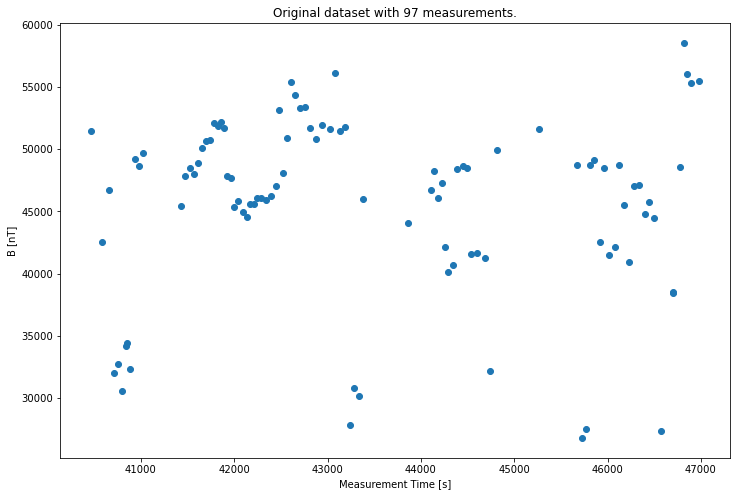

In [8]:
# Plotting all datapoints in order of appearance in the dataset

fig, ax = plt.subplots(figsize=(12, 8))

nData = len(data['field'])
ax.scatter(data['times'], data['field'])
ax.set(xlabel='Measurement Time [s]', ylabel='B [nT]', title=f'Original dataset with {nData} measurements.');
#plt.xticks(ticks=range(0, len(times), 200), labels=times[::200], rotation=45);

<ipython-input-9-4dc2b8a45a77>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:}'.format(int(_)) for _ in ax.get_xticks().tolist()]) # Fixes x-axis tick labels
<ipython-input-9-4dc2b8a45a77>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


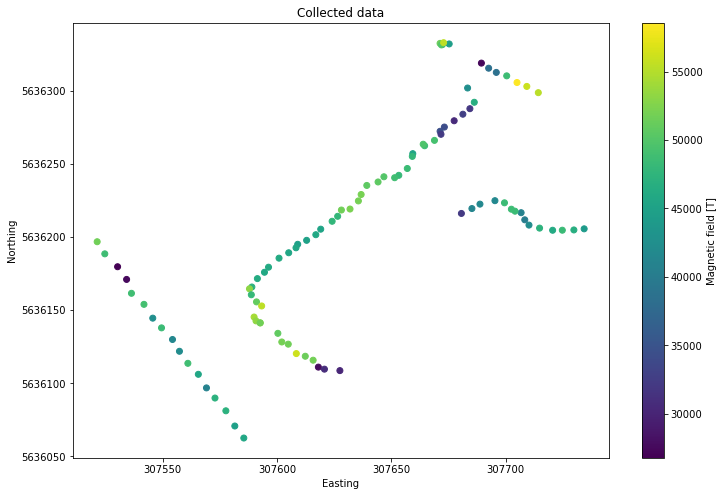

In [9]:
# Plotting the collected data spatially
fig, ax = plt.subplots(figsize=(12, 8))

# Using the temporally corrected anomalies
im = ax.scatter(data['x'], data['y'], c=data['field'])
ax.set(xlabel='Easting', ylabel='Northing', title='Collected data')
ax.set_xticklabels(['{:}'.format(int(_)) for _ in ax.get_xticks().tolist()]) # Fixes x-axis tick labels
ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic field [T]');

## Getting accurate altitude values

The altitudes recorded with your phones' GPS are likely imprecise. We can get accurate altitude values from a DEM of the survey area:

In [10]:
# Loading the DEM
# Enter the DEM location and name here (location must be specified relative to this notebook's folder)
dem_location = 'Drwiss_combined.txt'
dem = pd.read_csv(dem_location, sep=' ', names=['easting', 'northing', 'z'])

In [11]:
z_dem = []

for _x, _y in zip(data['x'], data['y']):
    _x = round(_x, 0)
    _y = round(_y, 0)
    mask = np.logical_and(dem['easting'] == _x, dem['northing'] == _y)
    p = dem.loc[mask]
    z_dem.append(p['z'].values[0].copy())
    
data['z_dem'] = z_dem

## Handling Outliers

We can now search the dataset for any outliers. There are many ways of defining and identifying outliers, here we will define a threshold value above or below which we want to discard any values. The median of the data will be our point of reference, and any field value lying above or below a predefined range around the median will be discarded.

In [12]:
# Here we set the unilateral range around the median, which defines the window of values we want to keep
rangespan = 10000
median_data = data['field'].median()

# Creating a vector with the absolute differences between each field value and the median
diff_median = np.abs(data['field'] - median_data)

# Storing all datapoints that do not meet the outlier criterion
data_outlier = data.loc[diff_median < rangespan]

# This new dataframe is now void of outliers

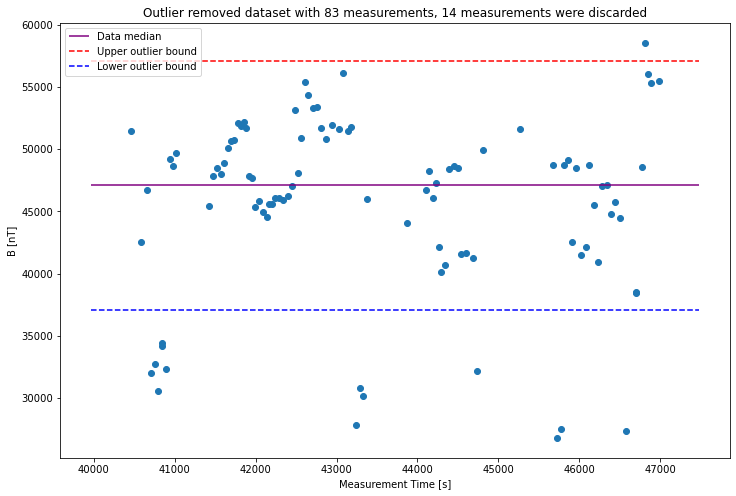

In [13]:
# Now we can plot the dataset with outliers removed
fig, ax = plt.subplots(figsize=(12, 8))

nDataOutlier = len(data_outlier['field'])
ax.scatter(data['times'], data['field'])
ax.hlines(median_data, data['times'].min()-500, data['times'].max()+500, color='purple', label='Data median')
ax.hlines(median_data+rangespan, data['times'].min()-500, data['times'].max()+500,
          linestyles='dashed', color='red', label='Upper outlier bound')
ax.hlines(median_data-rangespan, data['times'].min()-500, data['times'].max()+500,
          linestyles='dashed', color='blue', label='Lower outlier bound')
ax.set(xlabel='Measurement Time [s]', ylabel='B [nT]',
       title=f'Outlier removed dataset with {nDataOutlier} measurements, {nData-nDataOutlier} measurements were discarded');
ax.legend()
#plt.xticks(ticks=range(0, len(times_outlier), 200), labels=times_outlier[::200], rotation=45);

## Data Correction

To obtain magnetic anomalies, we need to extract the anomal part of the data. This can be done by subtracting a calculated (or measured) magnetic field value from the data. Another method is to also correct for the temporal drift which naturally occurs, for which measurements at a base station are needed. In our case, we can also use the smartphone measurements taken at the reference location as base station data. Using these data will also eliminate any measurement deviations that occur between smartphones.

Note that only one appropriate method must be chosen.

## Getting Base Station Data

If we want to use smartphone measurements as base station values, we need to get the values that were taken at the reference point. Since GPS measurements are not entirely precise, we define a tolerance range around which we will accept measurements as base station values. Of course we also have to specify the reference points' coordinates.

<ipython-input-14-95c99e788341>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


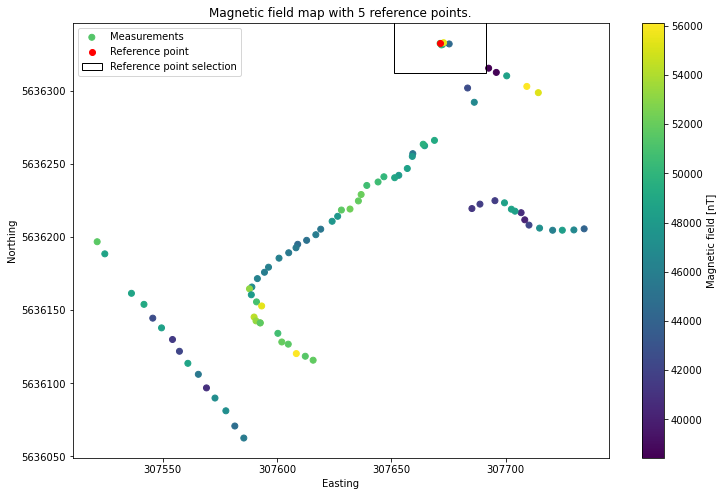

In [14]:
# Defining the reference location and tolerance
# Using first measurement location as default
refPointX = data_outlier['x'][0]
refPointY = data_outlier['y'][0]

# Defining the tolerance
tolX = 20
tolY = 20

refMinX, refMaxX = (refPointX-tolX, refPointX+tolX)
refMinY, refMaxY = (refPointY-tolY, refPointY+tolY)

maskX = np.logical_and(data_outlier['x'] < refMaxX, data_outlier['x'] > refMinX)
maskY = np.logical_and(data_outlier['y'] < refMaxY, data_outlier['y'] > refMinY)
maskAll = np.logical_and(maskX, maskY)

data_base = data_outlier.loc[maskAll]
nDataBase = len(data_base['x'])

# Plotting reference measurements
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.scatter(data_outlier['x'], data_outlier['y'], c=data_outlier['field'], clip_on=True, label='Measurements')
ax.set(xlabel='Easting', ylabel='Northing', title=f'Magnetic field map with {nDataBase} reference points.')
refArea = mpl.patches.Rectangle((refMinX, refMinY), width=refMaxX-refMinX, height=refMaxY-refMinY,
                               fill=False, label='Reference point selection')
ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
ax.add_artist(refArea)
im_ref = ax.scatter(refPointX, refPointY, c='r', zorder=3, label='Reference point')
plt.colorbar(im, ax=ax, label='Magnetic field [nT]')
ax.legend(handles=[im, im_ref, refArea]);

If the reference area includes less than 2 points, increase the tolerance. Once the base station values are obtained, they can be used in the time drift correction. Set the variable below to 'temporal' in order to use this type of corrrection. For a theoretical reference correction you can also use enter 'reference'.

## Altitude correction 



There is an altitude dependency of the magnetic field. This correction is undertaken before any other calculations are done, and will be done on the basis of a digital elevation model (DEM) of the area.

In [20]:
# Defining reference height for altitude correction
# Using first measurement location as reference
RefHeight = data_base['z_dem'][0]
dH = data_outlier['z_dem'] - RefHeight
R = RefHeight + 6371000 # (earth radius in m)
field_altitude = data_outlier['field']*(1+(dH/R))**(-3)
data_outlier['field_alt'] = field_altitude


<ipython-input-20-03f2b1693258>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier['field_alt'] = field_altitude


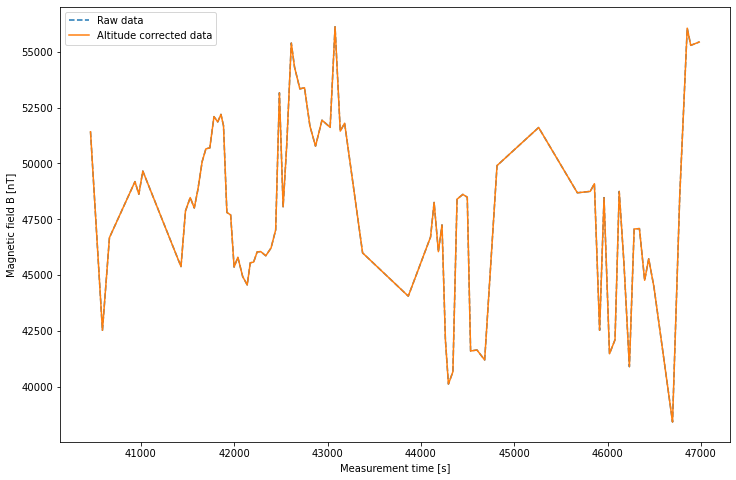

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(data_outlier['times'], data_outlier['field'], '--', label='Raw data')
ax.plot(data_outlier['times'], data_outlier['field_alt'], label='Altitude corrected data')
ax.set(xlabel='Measurement time [s]', ylabel='Magnetic field B [nT]')
ax.legend()


In [17]:
data_outlier


Station             y              x   height(m)        field  \
0    0.000000  5.636333e+06  307671.233552  109.568802  51418.17482   
1    1.005051  5.636302e+06  307683.265841  108.287073  42534.92094   
2    2.010101  5.636292e+06  307686.185858  111.907522  46681.98982   
9    9.045455  5.636266e+06  307668.787557  113.683069  49187.59834   
10  10.050505  5.636262e+06  307664.486598  112.886357  48622.50704   
..        ...           ...            ...         ...          ...   
91  91.459596  5.636313e+06  307695.812949  104.019462  38511.29496   
92  92.464646  5.636310e+06  307700.359485  103.987114  48558.51512   
94  94.474747  5.636303e+06  307709.149032  106.286880  56053.08787   
95  95.479798  5.636299e+06  307714.170472  105.183713  55283.98459   
96  96.484848  5.636333e+06  307672.779984  104.587847  55434.29339   

           t(s)         times   z_dem     field_alt  
0     28.932302  40459.342302  156.56  51418.174820  
1    156.812318  40587.222318  157.17  42041.587658  
2    231.912183  40662.322183  158.09  45339.695506  
9    505.412349  40935.822349  158.87  47073.053347  
10   546.772359  40977.182359  158.63  46743.778260  
..          ...           ...     ...           ...  
91  6266.600958  46697.010958  156.77  38356.739687  
92  6343.580924  46773.990924  156.78  48354.384050  
94  6423.660969  46854.070969  156.92  55668.187547  
95  6461.480788  46891.890788  156.91  54914.863444  
96  6552.400902  46982.810902  156.54  55455.543438  

[83 rows x 9 columns]

## Determining the anomalies

In [18]:
# Select here how you want to calculate anomalies: 'reference' or 'temporal'
anomaly_method = 'temporal'

### Time drift correction

The earth's magnetic field intensity changes throughout the day. If there is data available from a base station, the temporal drift can be measured and subtracted from the measured data. The base station data then also directly serves as a total field reference value, which means that the resulting values represent the magnetic anomaly relative to the base station location.
The anomaly can also be calculated by using a local theoretical reference value, which is demonstrated in the next section.

<ipython-input-19-d08b222d580d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier['anomaly'] = field_anomaly


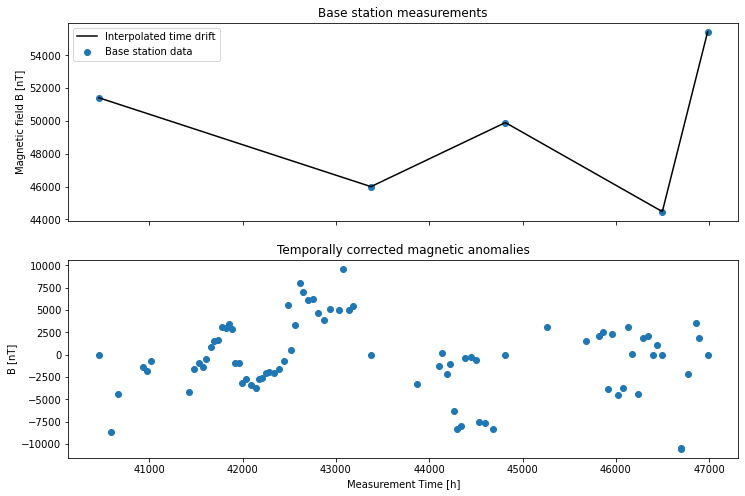

In [19]:
if anomaly_method == 'temporal':
    # In order to get basestation values for the exact times at which our actual measurements were taken,
    # we resample the basestation data. This is done via linear interpolation.

    baseline_interpolator = interpolate.interp1d(data_base['times'], data_base['field'], kind='linear',
                                                 fill_value='extrapolate')
    baseline_field = baseline_interpolator(data_outlier['times'])

    field_anomaly = data_outlier['field'] - baseline_field
    
    # Adding anomalies to dataframe
    data_outlier['anomaly'] = field_anomaly
    
    # Plotting the results

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    
    ax1.scatter(data_outlier['times'], data_outlier['anomaly'])
    ax1.set(xlabel='Measurement Time [h]', ylabel='B [nT]', title='Temporally corrected magnetic anomalies')
    
    ax0.scatter(data_base['times'], data_base['field'], label='Base station data')
    ax0.plot(data_outlier['times'], baseline_field, 'k', label='Interpolated time drift')
    ax0.set(title='Base station measurements', ylabel='Magnetic field B [nT]')
    ax0.legend();

### Substracting Reference Field

If there is no base station data available that can act as a local reference value, a theoretical backround value can be determined. Models for the earth's theoretical magnetic field are available, such as the [World Magnetic Model](http://geomag.bgs.ac.uk/data_service/models_compass/wmm_calc.html), which calculate the theoretical field value B for a given location. This can then be used to calculate deviations between our measurements and the 'ideal' value, returning the desired anomaly without accounting for any temporal trends.

In [ ]:
if anomaly_method == 'reference':
    # Here we define the background value for the correction, taken from literature or a suitable model
    reference = 49000 # nT

    field_anomaly = data_outlier['field'] - reference
    data_outlier['anomaly'] = field_anomaly
    # Plotting the results

    fig, ax = plt.subplots(figsize=(12,8))

    ax.scatter(data_outlier['times'], data_outlier['anomaly'])
    ax.set(xlabel='Datapoint Nr.', ylabel='B [nT]', title='Theoretical magnetic anomalies')

## Spatial anomaly plot

Once we calculated our anomalies we can display them as a spatial map.

The basic way to do this is a scatterplot with color-coded markers.

In [ ]:
# Basic Anomaly map
vmin = -np.max(np.abs(data_outlier['anomaly']))
vmax = np.max(np.abs(data_outlier['anomaly']))

fig, ax = plt.subplots(figsize=(12, 8))

# Using the temporally corrected anomalies
im = ax.scatter(data_outlier['x'], data_outlier['y'], c=data_outlier['anomaly'],
                vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.set(xlabel='Easting', ylabel='Northing', title='Field anomaly map')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]');

We can also produce a more sophisticated, continous map of our data using interpolation. Several common interpolation algorithms exist, such as polynomial interp., spline interp., and kriging.

A very straight-forward interpolation method is Nearest Neighbors, which simply assigns the unsampled point of interest the value of the sampled point that lies closest.

In [ ]:
# Defining a grid of points for which we want to interpolate
# Defining resolution (number of gridpoints) in x- and y- direction
xRes = 100
yRes = xRes

xAxis = np.linspace(data_outlier['x'].min(), data_outlier['x'].max(), xRes)
yAxis = np.linspace(data_outlier['y'].min(), data_outlier['y'].max(), yRes)

# Numpy offers the meshgrid function which simplifies some input operations
mgX, mgY = np.meshgrid(xAxis, yAxis)

In [ ]:
# Performing interpolation for all gridpoints
nearest_neighbors = interpolate.griddata(list(zip(data_outlier['x'], data_outlier['y'])), data_outlier['anomaly'],
                                         list(zip(mgX.flat, mgY.flat)), method='nearest')

In [ ]:
# plotting as a smooth contour map

fig, ax = plt.subplots(figsize=(12, 8))

ax.contourf(mgX, mgY, nearest_neighbors.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

In [ ]:
# Spline interpolation

linear_spline = interpolate.griddata(list(zip(data_outlier['x'], data_outlier['y'])), data_outlier['anomaly'],
                                     list(zip(mgX.flat, mgY.flat)), method='linear')

In [ ]:
fix, ax = plt.subplots(figsize=(12, 8))

ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from linear spline interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

## Saving the results

As a last step, we save our results. There are a multitude of ways and fileformats to achieve this. Since we want to store numerical data, [Numpy's savez function](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) is a fast and effective method to achieve this. We save the calculated anomalies as well as all data processing steps in between. We also save the interpolation results.

In [ ]:
# Save the data. Give your datafile a name so it can be distinguished from the others.

yourName = 'example'
fileName = 'results_magnetic_' + yourName + '.csv'
baseFileName = 'results_magneticBASE_' + yourName + '.csv'
folder = Path('results')
data_outlier['name'] = [yourName]*len(data_outlier)
data_base['name'] = [yourName]*len(data_base)

data_outlier.to_csv(folder / fileName)
data_base.to_csv(folder/ baseFileName)